In [1]:
from model import *
from model2 import *
import matplotlib.pyplot as plt
import os
from os.path import join
import numpy as np

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [2]:
#Creating list of image paths
image_dir = "dataset/Train/Image"
imgs = os.listdir(image_dir)
img_paths = [join(image_dir, filename) for filename in imgs]

#Creating list of mask paths
mask_dir = "dataset/Train/Label"
masks = os.listdir(mask_dir)
mask_paths = [join(mask_dir, filename) for filename in masks]

In [3]:
#For Target Size
image_size = 256

#Function for creating input array
def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path,
                     color_mode='grayscale',
                     target_size=(img_height, img_width)) for img_path in img_paths]
    
    img_array = np.array([img_to_array(img) for img in imgs])
    img_array /=255
    return(img_array)

def read_and_prep_masks(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path,
                     color_mode='grayscale',
                     target_size=(img_height, img_width)) for img_path in img_paths]
    
    img_array = np.array([img_to_array(img) for img in imgs])
    return(img_array)

In [4]:
#Create input for model
train_imgs = read_and_prep_images(img_paths)
train_masks = read_and_prep_masks(mask_paths)

In [5]:
train_imgs.shape

(829, 256, 256, 1)

In [6]:
train_masks.shape

(829, 256, 256, 1)

In [7]:
#One-Hot encode masks
train_masks = train_masks[...,0]
train_masks=to_categorical(train_masks, num_classes=4)

In [8]:
train_masks.shape

(829, 256, 256, 4)

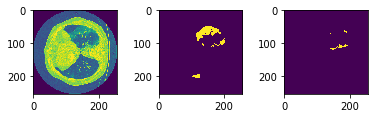

In [9]:
#Drawing example Image and mask
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,3,1)
plt.imshow(train_imgs[30,:,:,0])
plt.subplot(1,3,2)
plt.imshow(train_masks[30,:,:,1])
plt.subplot(1,3,3)
plt.imshow(train_masks[30,:,:,2])

In [10]:
#Initializing model
model = unet2()

In [11]:
model_EarlyStopping = EarlyStopping(monitor='val_loss',
                                    patience=2,
                                    restore_best_weights=True)

In [12]:
model.fit(train_imgs,
          train_masks,batch_size=4,
          epochs = 10,
          validation_split=0.3,
          shuffle=True,
          callbacks=[model_EarlyStopping]
          )


Train on 580 samples, validate on 249 samples
Epoch 1/10
580/580 [==============================] - 105s 180ms/step - loss: 1.3991 - dice_coeff: 0.0037 - accuracy: 0.3209 - val_loss: 1.3704 - val_dice_coeff: 0.0122 - val_accuracy: 0.2419
Epoch 2/10
580/580 [==============================] - 95s 164ms/step - loss: 1.3405 - dice_coeff: 0.0058 - accuracy: 0.6250 - val_loss: 3.6689 - val_dice_coeff: 0.0181 - val_accuracy: 0.0244
Epoch 3/10
580/580 [==============================] - 95s 164ms/step - loss: 1.2818 - dice_coeff: 0.0057 - accuracy: 0.8553 - val_loss: 1.3856 - val_dice_coeff: 0.0131 - val_accuracy: 0.7683


In [13]:
#Test data
from data import testGenerator
testGene = testGenerator("dataset/Test/Image", num_image = 20)
results = model.predict_generator(testGene,20,verbose=1)

20/20 [==============================] - 2s 75ms/step


In [14]:
results.shape

(20, 256, 256, 4)

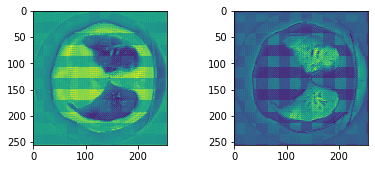

In [15]:
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
plt.imshow(results[0,:,:,0])
plt.subplot(1,2,2)
plt.imshow(results[0,:,:,1])

In [16]:
#segmented out lung part, better than first model